In [2]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [4]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_vggish_Zamuro = f"{root}/Zamuro/vggish/Features_vggish"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

In [5]:
X_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_filenames.pth")
y_vgg = [i.split('/')[6:8] for i in y_vgg]
for i in range(len(y_vgg)):
    y_vgg[i] = f"{y_vgg[i][0]}_{y_vgg[i][1]}"

In [6]:
X_add = []
for i in range(len(X_vgg)):
    if(X_vgg[i].shape == torch.Size([62, 128])):
        X_add.append(i)
X_vgg2 = []
y_vgg2 = []
for i, value in enumerate(X_add):
    X_vgg2.append(X_vgg[value])
    y_vgg2.append(y_vgg[value])
X_vgg2 = torch.stack(X_vgg2)
X_vgg2 = X_vgg2.numpy()
X_vgg2 = X_vgg2.reshape(X_vgg2.shape[0], X_vgg2.shape[1]*X_vgg2.shape[2])

In [7]:
df_vgg = pd.DataFrame(X_vgg2)
df_vgg["y"] = y_vgg2
df_vgg
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['cover'] = df_vgg.index.map(audios['cover'])
df_vgg['rain_FI'] = df_vgg.index.map(audios['rain_FI'])

In [8]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_vgg[['location', 'day', 'hour']] =df_vgg['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_vgg['hour_stage'] =df_vgg['hour'].apply(define_hour_stage)
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['cover'] = df_vgg.index.map(audios['cover'])
df_vgg = df_vgg[df_vgg['rain_FI'] == 'NO']

In [13]:
df_vgg

,0,1,2,3,4,5,6,7,8,9,...,7933,7934,7935,y,cover,rain_FI,location,day,hour,hour_stage
y,,,,,,,,,,,,,,,,,,,,,
RZUA01_20220906_063000.WAV,156.0,12.0,170.0,62.0,207.0,82.0,80.0,98.0,213.0,212.0,...,0.0,116.0,255.0,RZUA01_20220906_063000.WAV,pasture,NO,RZUA01,06,06,morning
RZUA01_20220903_110000.WAV,154.0,4.0,157.0,56.0,200.0,78.0,74.0,97.0,220.0,208.0,...,0.0,49.0,255.0,RZUA01_20220903_110000.WAV,pasture,NO,RZUA01,03,11,day
RZUA01_20220903_111500.WAV,153.0,13.0,165.0,51.0,209.0,81.0,100.0,104.0,204.0,230.0,...,0.0,162.0,255.0,RZUA01_20220903_111500.WAV,pasture,NO,RZUA01,03,11,day
RZUA01_20220903_174500.WAV,147.0,13.0,159.0,53.0,233.0,84.0,119.0,90.0,179.0,212.0,...,0.0,0.0,255.0,RZUA01_20220903_174500.WAV,pasture,NO,RZUA01,03,17,night
RZUA01_20220903_180000.WAV,156.0,18.0,166.0,71.0,224.0,68.0,99.0,88.0,200.0,212.0,...,115.0,255.0,255.0,RZUA01_20220903_180000.WAV,pasture,NO,RZUA01,03,18,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUD01M_20220911_074500.WAV,151.0,0.0,175.0,41.0,191.0,63.0,130.0,64.0,228.0,255.0,...,0.0,164.0,255.0,RZUD01M_20220911_074500.WAV,pasture,NO,RZUD01M,11,07,morning
RZUD01M_20220911_080000.WAV,151.0,14.0,181.0,57.0,228.0,61.0,136.0,97.0,205.0,231.0,...,0.0,95.0,255.0,RZUD01M_20220911_080000.WAV,pasture,NO,RZUD01M,11,08,morning
RZUD01M_20220911_081500.WAV,155.0,11.0,173.0,60.0,175.0,41.0,136.0,60.0,224.0,255.0,...,0.0,230.0,255.0,RZUD01M_20220911_081500.WAV,pasture,NO,RZUD01M,11,08,morning


## All classification

Accuracy: 0.6680837906779006
f1: 0.5214344252226287
recall 0.5084978499011562
[[0.06191544 0.10697998 0.03215583]
 [0.02094767 0.54510319 0.01777846]
 [0.04011749 0.11393677 0.06106516]]
[[ 801 1384  416]
 [ 271 7052  230]
 [ 519 1474  790]]


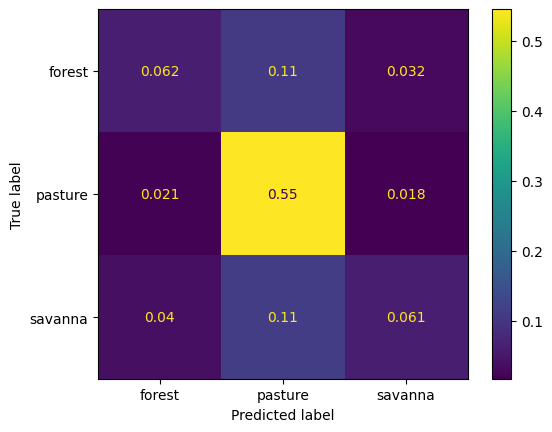

In [12]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_vgg.iloc[:,0:60])
y = np.asarray(df_vgg.loc[:,"cover"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)

confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")

print(confusion_matrix_norm)

print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])

# display matrix
cm_display.plot()
plt.show()


## Cover

In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_covers = []
f1_scores_vgg_covers = []
recalls_vgg_covers = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_vgg[df_vgg['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:7935])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_covers.append(accuracy)
    f1_scores_vgg_covers.append(f1_score)
    recalls_vgg_covers.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_covers.npy", accuracies_vgg_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_covers.npy", f1_scores_vgg_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_covers.npy", recalls_vgg_covers)

Accuracy: 0.7445887445887446
f1: 0.47520272058022445
recall 0.45817307692307696
Accuracy: 0.7348560079443893
f1: 0.5510218591597013
recall 0.5216553221136321
Accuracy: 0.6949585194639438
f1: 0.5513061507053496
recall 0.5320303323778464
Accuracy: 0.6902298850574713
f1: 0.5680789811128818
recall 0.5508497812247198
Accuracy: 0.6886467889908257
f1: 0.5562443397539469
recall 0.5407705627538045
Accuracy: 0.672939649578196
f1: 0.512846129733476
recall 0.5004684600207076
Accuracy: 0.7117117117117117
f1: 0.6145351814079758
recall 0.6024766836331318
Accuracy: 0.7027632561613144
f1: 0.5843040242426039
recall 0.5652644558852652
Accuracy: 0.6933139534883721
f1: 0.538519657203254
recall 0.5189712455566114
Accuracy: 0.6822857142857143
f1: 0.5250763537892251
recall 0.5081107702308473
Accuracy: 0.75
f1: 0.5220664392642104
recall 0.4889752407644405


In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_hours = []
f1_scores_vgg_hours = []
recalls_vgg_hours = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_vgg[df_vgg['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:7935])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_hours.append(accuracy)
    f1_scores_vgg_hours.append(f1_score)
    recalls_vgg_hours.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_hours.npy", accuracies_vgg_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_hours.npy", f1_scores_vgg_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_hours.npy", recalls_vgg_hours)

Accuracy: 0.8744588744588745
f1: 0.544538504951003
recall 0.5466715794645051
Accuracy: 0.8043694141012909
f1: 0.6801789829725702
recall 0.6636315440689199
Accuracy: 0.7925973197192087
f1: 0.685916507724201
recall 0.6796180111550197
Accuracy: 0.8091954022988506
f1: 0.744113094338467
recall 0.7379110407412295
Accuracy: 0.8302752293577982
f1: 0.7576789393014014
recall 0.7532690485835275
Accuracy: 0.7560025957170668
f1: 0.7062505941711029
recall 0.703047714069536
Accuracy: 0.7723177723177723
f1: 0.6099180676509789
recall 0.6041618468807569
Accuracy: 0.7513069454817027
f1: 0.5654124336623073
recall 0.5819439475253428
Accuracy: 0.7885174418604651
f1: 0.7115831865320104
recall 0.7050334006236699
Accuracy: 0.7851428571428571
f1: 0.7525824343343852
recall 0.761300908522797
Accuracy: 0.7878787878787878
f1: 0.7345715037449958
recall 0.719786505032825


In [6]:
# y_ = np.asarray(y_path)
# y_2 = y_[:,0]
# for i in range(len(y_2)):
#     y_2[i] = y_2[i][0:-2] 
# y_3 = list(y_2)

X_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_filenames.pth")
cont = 0
vgg_corrupted = []
X_corrupted = []
for i in range(len(X_vgg)):
    if(X_vgg[i].shape!= torch.Size([62, 128])):
        vgg_corrupted.append(y_vgg[i])
        X_corrupted.append(i)
for i in range(len(vgg_corrupted)):
    y_vgg.remove(vgg_corrupted[i])        
X_vgg = np.delete(X_vgg, X_corrupted)


y_vgg2 = [i.split('/')[6:8] for i in y_vgg]
X_vgg2 = []
for i in range(len(y_vgg2)):
    y_vgg2[i] = f"{y_vgg2[i][0]}_{y_vgg2[i][1]}"

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### VGGish data

In [5]:
y_ = np.asarray(y_path)
y_2 = y_[:,0]
for i in range(len(y_2)):
    y_2[i] = y_2[i][0:-2] 
y_3 = list(y_2)

X_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_filenames.pth")
cont = 0
vgg_corrupted = []
X_corrupted = []
for i in range(len(X_vgg)):
    if(X_vgg[i].shape!= torch.Size([62, 128])):
        vgg_corrupted.append(y_vgg[i])
        X_corrupted.append(i)
for i in range(len(vgg_corrupted)):
    y_vgg.remove(vgg_corrupted[i])        
X_vgg = np.delete(X_vgg, X_corrupted)


y_vgg2 = [i.split('/')[6:8] for i in y_vgg]
X_vgg2 = []
for i in range(len(y_vgg2)):
    y_vgg2[i] = f"{y_vgg2[i][0]}_{y_vgg2[i][1]}"
    
X_vgg2 = []
remove = []
keep_idx = []
y_vggp = []

for i in range(len(y_vgg2)):
    #a[i] = X_vgg2[i]
    if y_vgg2[i] not in y_3:
        remove.append(y_vgg2[i])
    else:
        keep_idx.append(i)
        
# for i in range(len(remove)): 
#     y_vgg2.remove(remove[i])
    
for i in keep_idx:
    X_vgg2.append(X_vgg[i])
    y_vggp.append(y_vgg2[i])
    


y_vgg2 = y_vggp

remove = []
keep_idx = []
X_2 = []
y_vgg3 = []
for i in range(len(y_3)):
    if y_3[i] not in y_vgg2:
        remove.append(y_vgg2[i])
    else:
        keep_idx.append(i)

X_1 = np.reshape(X_scaled, (X_scaled.shape[0]//5, 5, X_scaled.shape[1]))

# for i in range(len(remove)): 
#     y_3.remove(remove[i])
    
for i in keep_idx:
    y_vgg3.append(y_3[i])
    X_2.append(X_1[i])
    
X_3 = np.asarray(X_2)
X_3 = np.reshape(X_3, (X_3.shape[0]*X_3.shape[1], X_3.shape[2]))
y_4 = np.repeat(y_vgg3, 5)
        
print(len(y_4), len(X_3))
    
X_vgg3 = np.zeros([len(X_vgg2),62,128])
for i in range (len(X_vgg2)):
    X_vgg3[i] = X_vgg2[i].numpy()
    
X_vgg4 = X_vgg3.reshape(X_vgg3.shape[0], X_vgg3.shape[1]*X_vgg3.shape[2])
labels_vgg = []
for i in range(len(y_vgg2)):
    labels_vgg.append(audios.loc[y_vgg2[i], "cover"])
    
from sklearn.model_selection import train_test_split
X_train, X_test, labels_train, labels_test = train_test_split(X_vgg4, labels_vgg, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy_vggish = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score_vggish = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall_vggish = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy_vggish)
print("f1:", f1_score_vggish)
print("recall", recall_vggish)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


323415 323415
Accuracy: 0.6902682229264899
f1: 0.5483968905627624
recall 0.5307180470440016


### Acoustic Indices Data

In [6]:
X_ai = []
remove = []
s=0
for i in range(len(y_3)):
    
    try:
        X_ai.append(ai.loc[y_3[i]])
    except:
        s+=1
        remove.append(y_3[i])
for i in range(len(remove)):
    y_3.remove(remove[i])
X_ai = np.asarray(X_ai)

labels_ai = []
# audios.set_index("Filename", inplace=True)
for i in range(len(y_3)):
    labels_ai.append(audios.loc[y_3[i], "cover"])
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ai, labels_ai, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy_ai = metrics.accuracy_score(y_test, y_pred_rf)
f1_score_ai = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall_ai = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy_ai)
print("f1:", f1_score_ai)
print("recall", recall_ai)

Accuracy: 0.815322643117205
f1: 0.7591179914466922
recall 0.7317228748513335


### Autoencoders Features and Labels using independent segments

In [7]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# audios.set_index("Filename", inplace=True)
labels_ae = []
for i in range(len(y_4)):
    labels_ae.append(audios.loc[y_4[i], "cover"])

X_train, X_test, y_train, y_test = train_test_split(X_3, labels_ae, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


Accuracy: 0.7849357636473262
f1: 0.7120130488177298
recall 0.6865794895942456


### Autoencoders Features and Labels using 5 segments of the audio

In [8]:
X_c = X_3
y_c = y_4

X_batch = np.reshape(X_c, (X_c.shape[0]//5,5,X_c.shape[1]))
y_path = np.reshape(y_c, (y_c.shape[0]//5, 5))

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_path, test_size=0.2,random_state=0)

X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

labels_train = []
for i in range(len(y_train)):
    labels_train.append(audios.loc[y_train[i], "cover"])
labels_test = []
for i in range(len(y_test)):
    labels_test.append(audios.loc[y_test[i], "cover"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

# Autoencoders Features and Labels using voting labels

In [ ]:
y_pred_rf2 = np.asarray(y_pred_rf)
y_pred_rf2 = np.reshape(y_pred_rf2,(y_pred_rf2.shape[0]//5,5))
y_test2 = np.asarray(labels_test)
y_test2 = np.reshape(y_test2,(y_test2.shape[0]//5,5))

def most_frequent(List):
    return max(set(List), key = List.count)

labels_test2 = []
labels_pred = []
for i in range(len(y_pred_rf2)):
    labels_pred.append(most_frequent(list(y_pred_rf2[i])))
    labels_test2.append(most_frequent(list(y_test2[i])))
accuracy_ae = metrics.accuracy_score(labels_test2, labels_pred)
f1_score_ae = metrics.f1_score(labels_test2, labels_pred, average="macro")
recall_ae = metrics.recall_score(labels_test2, labels_pred, average="macro")

print("Accuracy:", accuracy_ae)
print("f1:", f1_score_ae)
print("recall", recall_ae)

# Autoencoders Features and Labels using mean of segments

In [ ]:
X_New = np.load(f"temporal_zamuro/Features/X_ae_norm_new.npy")
y_New = np.load(f"temporal_zamuro/Features/y_ae_norm_new.npy")
labels_aenew = audios.loc[y_New]
labels_aenew = list(labels_aenew["cover"])


In [ ]:
X_B =np.asarray(X_2)
X_B.shape

In [ ]:
X_New = np.mean(X_B, axis=1)
# X_New = X_New[0:len(y_3)]
# y_New = y_New[0:len(y_3)]

X_New.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_New, labels_aenew, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

In [ ]:
f1_scores = [f1_score_ai, f1_score_ae, f1_score_vggish] # [ai, AE_norm, AE_PCA, AE_UMAP, VGGISH, VGGISH_PCA, VGGISH_UMAP]
accuracy_scores = [accuracy_ai, accuracy_ae, accuracy_vggish]
recall_scores = [recall_ai, recall_ae, recall_vggish]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for F1 scores, recall, and accuracy
methods = ["Acoustic\nIndices", "AE Normalized", "vggish"]

# Create an array for the x-axis positions
x = np.arange(len(methods))

# Set the figure size
plt.figure(figsize=(11, 6))

# Width of the bars
bar_width = 0.2

# Define professional color palettes
f1_color = 'steelblue'  # You can adjust the color as needed
recall_color = 'indianred'  # You can adjust the color as needed
accuracy_color = 'orange'  # You can adjust the color as needed

# Create the bar chart for F1 scores
bars_f1 = plt.bar(x - bar_width, f1_scores, bar_width, label='F1 Score', color=f1_color)

# Create the bar chart for recall
bars_recall = plt.bar(x, recall_scores, bar_width, label='Recall', color=recall_color)

# Create the bar chart for accuracy
bars_accuracy = plt.bar(x + bar_width, accuracy_scores, bar_width, label='Accuracy', color=accuracy_color)

# Set the y-axis limits
plt.ylim(0.5, 1)

# Set the x-axis labels and their positions
plt.xticks(x, methods, fontsize=14)  # Increase label size

# Set the y-axis label
plt.ylabel('Score')

# Set the title
# plt.title('F1 Score, Recall, and Accuracy Comparison')

# Set the legend with increased size
plt.legend(fontsize=14)  # Increase legend size

# Add values on top of the bars
for bar, value in zip(bars_f1, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_recall, recall_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_accuracy, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

# Add a legend
# plt.legend()

# Display the figure

# plt.savefig(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/zamuro_classification.pdf", format="pdf")